In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [16]:
# Read in data:

trans = pd.read_csv('Cust Transactions.csv')
trans.head()

,Unnamed: 0,CustID,TransDate
0,0,100033,2018-01-01
1,1,100038,2018-01-01
2,2,100084,2018-01-01
3,3,100101,2018-01-01
4,4,100107,2018-01-01


In [17]:
# Group same-day transactions for each customer and get the date of first transaction of each customer:
# Remove the first column:

first_trans = trans.groupby(by = 'CustID')['TransDate'].min()\
                    .reset_index()\
                    .rename(columns = {'TransDate':'FirstTrans'})
cust_trans = trans.merge(first_trans, on = 'CustID')[['CustID', 'TransDate']]
cust_trans.head()

,CustID,TransDate
0,100033,2018-01-01
1,100033,2018-01-04
2,100033,2018-01-07
3,100033,2018-01-10
4,100033,2018-01-11


In [19]:
# Transform customer transaction records to individual-level calibration and holdout summary data.
# (This is called CBS matrix: Customer-by-Sufficient-Statistic matrix):

from lifetimes.utils import calibration_and_holdout_data
CBS = calibration_and_holdout_data(cust_trans,\
                                   'CustID', 'TransDate', \
                                    calibration_period_end='2018-12-31', \
                                    observation_period_end='2019-06-10' ).reset_index()

CBS = CBS.merge(first_trans, on = 'CustID')
CBS.head()

,CustID,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,FirstTrans
0,100001,0.0,0.0,327.0,0.0,161,2018-02-07
1,100005,1.0,72.0,193.0,0.0,161,2018-06-21
2,100006,4.0,133.0,268.0,1.0,161,2018-04-07
3,100011,15.0,334.0,336.0,12.0,161,2018-01-29
4,100015,45.0,358.0,361.0,5.0,161,2018-01-04


In [20]:
# Import packages for model fitting:

from lifetimes.utils import *
from lifetimes import BetaGeoFitter
from lifetimes import ParetoNBDFitter
from lifetimes.plotting import *

bgf = BetaGeoFitter()
pnf = ParetoNBDFitter()

In [21]:
bgnbd_model = bgf.fit(CBS['frequency_cal'], CBS['recency_cal'], CBS['T_cal'])
bgnbd_model

<lifetimes.BetaGeoFitter: fitted with 137667 subjects, a: 0.12, alpha: 5.60, b: 0.88, r: 0.28>

In [22]:
# Simulate calibration visits based on estimated bg/nbd model parameters:

simulated_bgnbd = bgf.generate_new_data(size = len(CBS))
simulated_bgnbd.head()

,frequency,recency,T,lambda,p,alive
customer_id,,,,,,
0.0,0.0,0.000000,327.0,0.006389,0.002465,1.0
1.0,0.0,0.000000,193.0,0.005902,0.178649,1.0
2.0,12.0,196.396340,268.0,0.042824,0.001159,1.0
3.0,0.0,0.000000,336.0,0.000231,0.019603,1.0
4.0,1.0,175.270211,361.0,0.007442,0.022955,1.0


In [23]:
# Define function to transform individual-level actual calibration and holdout summary data to data frame
# with columns of 'freq' and 'count':

def transform_cal_hold_to_freq_count(df):
    return pd.DataFrame(df['frequency_cal'].value_counts().sort_index())\
                    .reset_index().rename(columns = {'index':'freq','frequency_cal':'count'})

In [24]:
# Define function to transform simulated data to dataframe with columns of 'freq' and 'count':

def transform_sim_to_freq_count(df):
    return pd.DataFrame(df['frequency'].value_counts().\
                        sort_index().reset_index().\
                        rename(columns = {'index': 'freq', 'frequency': 'count'}))

In [25]:
# Define function to bin frequencies for dataframe with columns named 'freq' and 'count':

def binned_max_freq(df,max_x):
    return df.loc[0:max_x].append({'freq':str(max_x) + '+',\
                                   'count':df[df.iloc[:,0] >= max_x].iloc[:,1].sum()},\
                                        ignore_index = True)

In [26]:
# Transform individual-level actual calibration and holdout summary data to data frame (customer by sufficient statistics):

actual_cal_freq = transform_cal_hold_to_freq_count(CBS)

# Transform simulated data to dataframe with columns of 'freq' and 'count':

simulated_cal_freq_bgnbd = transform_sim_to_freq_count(simulated_bgnbd)

In [27]:
# Group transformed actual and simulated data with max frequency of 40:

actual_binned = binned_max_freq(actual_cal_freq, 40)
simulated_binned_bgnbd = binned_max_freq(simulated_cal_freq_bgnbd, 40)

In [28]:
# Merge actual and simulated frequency and count data to get a table that counts the actual number and simulated
# number of patrons who made 0, 1, 2, ..., 40+ repeat transactions during calibration period.
# This table is used to generate the bar plot which show the comparison of actual counts and simulated counts
# of each visit frequency.
# Below shows first five row of this table:

cal_actual_sim_bgnbd = actual_binned.merge(simulated_binned_bgnbd, how = 'outer', on = 'freq')
cal_actual_sim_bgnbd = cal_actual_sim_bgnbd.rename\
            (columns ={'freq':'visits' ,'count_x':'actual_counts','count_y':"simulated_counts"})
cal_actual_sim_bgnbd['visits'] = cal_actual_sim_bgnbd['visits'].astype(str)
cal_actual_sim_bgnbd.head()

,visits,actual_counts,simulated_counts
0,0.0,53840,50702
1,1.0,19275,22838
2,2.0,10242,10873
3,3.0,6476,6911
4,4.0,4541,5138


Text(0, 0.5, 'Number of Players')

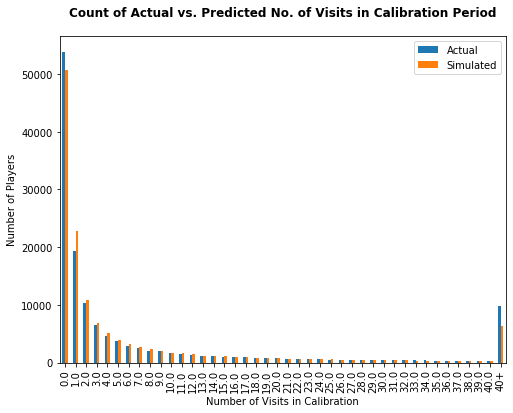

In [29]:
# Plot actual visits vs. simulated visits during calibration period under estimated bg/nbd model:

%matplotlib inline
bgnbd_actual_pred_cal_plot = cal_actual_sim_bgnbd.plot(kind = 'bar', figsize = (8,6))
bgnbd_actual_pred_cal_plot.set_title('Count of Actual vs. Predicted No. of Visits in Calibration Period',\
                                      fontweight = "bold", pad = 20)
bgnbd_actual_pred_cal_plot.legend(['Actual','Simulated'])
bgnbd_actual_pred_cal_plot.set_xticklabels(cal_actual_sim_bgnbd['visits'])[0]
bgnbd_actual_pred_cal_plot.set_xlabel('Number of Visits in Calibration')
bgnbd_actual_pred_cal_plot.set_ylabel('Number of Players')

In [33]:
# Define function to generate data frame with actual frequency and predicted freqency at holdout period
# from original individual-level calibration and holdout summary data (customer by sufficient statistics, or CBS):

def generate_actual_pred_holdout_bgnbd(df):
    
    bgnbd_model = bgf.fit(df['frequency_cal'], df['recency_cal'], df['T_cal'])
    
    df['predict_holdout_bgnbd'] = bgnbd_model.predict(df['duration_holdout'],\
                                                      df['frequency_cal'],\
                                                      df['recency_cal'],\
                                                      df['T_cal'])
    df = df.reset_index()
    prediction = df.loc[:,['CustID','frequency_holdout','predict_holdout_bgnbd']]
    prediction['predict_holdout_bgnbd'] = prediction['predict_holdout_bgnbd'].fillna(0)
    prediction['predict_round_bgnbd'] = prediction['predict_holdout_bgnbd'].astype(int)
    
    return prediction

In [34]:
# Generate predicted number of visits for each player during holdout period under BG/NBD:

predict_holdout_bgnbd = generate_actual_pred_holdout_bgnbd(CBS)
predict_holdout_bgnbd.head()

,CustID,frequency_holdout,predict_holdout_bgnbd,predict_round_bgnbd
0,100001,0.0,0.132173,0
1,100005,0.0,0.675793,0
2,100006,1.0,1.536230,1
3,100011,12.0,6.955938,6
4,100015,5.0,19.337787,19


In [35]:
# Generate table that counts the actual number and simulated number of patrons who made 
# 0, 1, 2, ..., 40+ repeat transactions during holdout period unde rBG/NBD Model:


holdout_actual_bgnbd = pd.DataFrame(predict_holdout_bgnbd["frequency_holdout"].value_counts().sort_index())\
                         .reset_index().rename(columns = {'index':'freq','frequency_holdout':'count'})
holdout_predict_bgnbd = pd.DataFrame(predict_holdout_bgnbd["predict_round_bgnbd"].value_counts().sort_index())\
                          .reset_index().rename(columns = {'index':'freq','predict_round_bgnbd':'count'})
    
hd_actual_bgnbd_binned = binned_max_freq(holdout_actual_bgnbd, 40)
hd_predict_bgnbd_binned = binned_max_freq(holdout_predict_bgnbd, 40)
    
hold_actual_pred_bgnbd = hd_actual_bgnbd_binned.merge(hd_predict_bgnbd_binned, how = 'outer', on = 'freq')
hold_actual_pred_bgnbd = hold_actual_pred_bgnbd.rename\
              (columns ={'freq':'transactions' ,'count_x':'actual_counts','count_y':"predicted_counts"})

hold_actual_pred_bgnbd.head()

,transactions,actual_counts,predicted_counts
0,0,77681,79086
1,1,15250,14113
2,2,8738,7952
3,3,5496,5594
4,4,3951,4120


Text(0, 0.5, 'Number of Players')

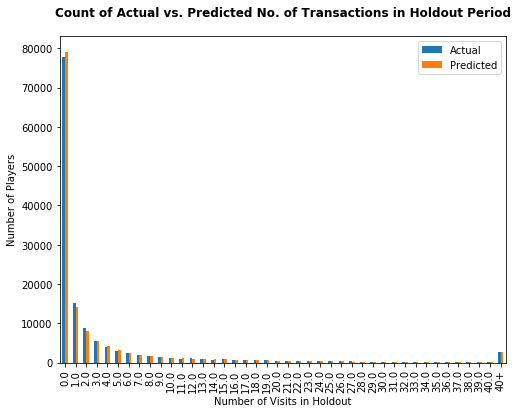

In [37]:
# Plot actual visits vs. simulated visits during holdout period:

%matplotlib inline
bgnbd_actual_pred_hold_plot = hold_actual_pred_bgnbd.plot(kind = 'bar', figsize = (8,6))
bgnbd_actual_pred_hold_plot.set_title('Count of Actual vs. Predicted No. of Transactions in Holdout Period',\
                                      fontweight = "bold", pad = 20)
bgnbd_actual_pred_hold_plot.legend(['Actual','Predicted'])
bgnbd_actual_pred_hold_plot.set_xticklabels(hold_actual_pred_bgnbd['transactions'])[0]
bgnbd_actual_pred_hold_plot.set_xlabel('Number of Visits in Holdout')
bgnbd_actual_pred_hold_plot.set_ylabel('Number of Players')

Text(45.125, 0.5, 'Density')

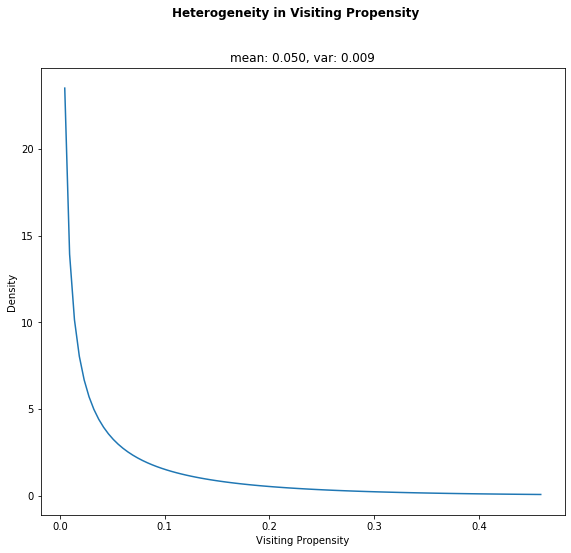

In [40]:
# Plot probability density function that reflects transaction rate heterogeneity:

%matplotlib inline

import matplotlib.pyplot as plt
import scipy
from scipy import *

r, alpha = bgnbd_model._unload_params("r", "alpha")
rate_mean = r / alpha
rate_var = r / alpha ** 2
rv = scipy.stats.gamma(r, scale=1 / alpha)
lim = rv.ppf(0.99)
x = np.linspace(0, lim, 100)

fig, ax = plt.subplots(figsize = (8,8))
fig.suptitle("Heterogeneity in Visiting Propensity", fontweight="bold")
fig.tight_layout(rect=[0, 0.05, 1, 0.9])
plt.plot(x, rv.pdf(x))

ax.set_title("mean: {:.3f}, var: {:.3f}".format(rate_mean, rate_var))
ax.set_xlabel('Visiting Propensity')
ax.set_ylabel('Density')

Text(45.125, 0.5, 'Density')

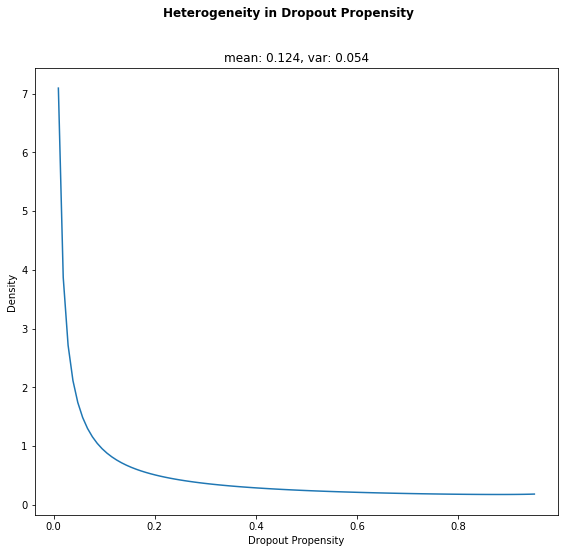

In [41]:
# Plotting the probability density function that reflects dropout rate heterogeneity:

%matplotlib inline

import matplotlib.pyplot as plt
from scipy import *

a, b = bgnbd_model._unload_params("a", "b")
beta_mean = a / (a + b)
beta_var = a * b / ((a + b) ** 2) / (a + b + 1)

rv = scipy.stats.beta(a, b)
lim = rv.ppf(0.99)
x = np.linspace(0, lim, 100)

fig, ax = plt.subplots(figsize = (8,8))
fig.suptitle("Heterogeneity in Dropout Propensity", fontweight = "bold")
fig.tight_layout(rect=[0, 0.05, 1, 0.9])
plt.plot(x, rv.pdf(x))

ax.set_title("mean: {:.3f}, var: {:.3f}".format(beta_mean, beta_var))
ax.set_xlabel('Dropout Propensity')
ax.set_ylabel('Density')

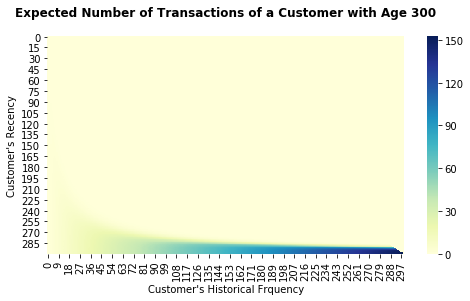

In [42]:
# Plotting the expected number of visits, given a customer of age t:

def plot_expected_future_trans(age, t):
    
    import matplotlib.pyplot as plt
    
    d = pd.DataFrame(np.zeros((age,age)))
    
    for i in range(age):
        for j in range(i):
            d.at[j,i] = bgf.predict(t, j, i, age)
    
    fig, ax = plt.subplots(figsize=(8,4))
    exp_future_trans = sns.heatmap(d.T,cmap = 'YlGnBu', ax = ax)
    exp_future_trans.set_title("Expected Number of Transactions of a Customer with Age " + str(age), \
                                fontweight = "bold", pad = 20)
    exp_future_trans.set_xlabel("Customer's Historical Frquency")
    exp_future_trans.set_ylabel("Customer's Recency")
    
    
    return exp_future_trans

plot_expected_future_trans(300,161)